In [1]:
!pip install tensorflow-text
!pip install tf-models-official

     |████████████████████████████████| 4.3MB 4.2MB/s 
     |████████████████████████████████| 1.6MB 4.3MB/s 
     |████████████████████████████████| 38.2MB 82kB/s 
     |████████████████████████████████| 358kB 32.6MB/s 
     |████████████████████████████████| 686kB 18.4MB/s 
     |████████████████████████████████| 215kB 38.4MB/s 
     |████████████████████████████████| 645kB 35.3MB/s 
     |████████████████████████████████| 61kB 6.3MB/s 
     |████████████████████████████████| 102kB 11.4MB/s 
     |████████████████████████████████| 1.2MB 20.1MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-cp37-none-any.whl size=22258 sha256=f3c68a39d3e715744dc22600b3724ec237ecec9341862d6c0bdfef6187eaac9f
  Stored in directory: /root/.cache/pip/wheels/2e/15/f5/aa2a056d223903b52cf4870134e3a01df0c723816835dd08db
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16184 sha256=64eba912493045142e5ba33c57a27d927601a

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_text as tftext
from official.nlp import optimization # Use for adamW
from official.nlp.bert import tokenization
from official.nlp.bert import bert_models
import tensorflow_hub as hub

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
import os
import re

In [5]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1", trainable=True)

# Lets load our dataset using tensorflow datasets
- We will be using the sentiment140
- Contains tweets with the following categories:
- You can read up here: https://www.tensorflow.org/datasets/catalog/sentiment140

In [7]:
(train_ds, valid_ds, test_ds), ds_info = tfds.load(
    'imdb_reviews', with_info=True, as_supervised=True,
    split=['train', 'test[50:]', 'test[:50]']
)

In [8]:
# Some eda to understand a bit
for text, label in train_ds.shuffle(1024).take(10):
  print(text.numpy(), label.numpy())

b"This movie is good for what it is, and unpretentious; I wouldn't watch it twice, however: I am a Peter Cushing completist and that's why I watched it. The best asset of this movie is: BREVITY and EFFECTIVENESS. Compared to other similar movies, it does NOT drag its feet forever as each of the four (plus one) segments lasts under 30 minutes, with the last under 10. Good uncanny vibes. In the first segment, horror writer suffering from 'writer's block' relocates to secluded old house seeking inspiration. He finds even too much of it when he starts to visualize one of his fictional madmen. Plot contrivance similar to PREMATURE BURIAL. Good use of the point-of-view twist: is the writer getting mentally ill...or (as the ending shows) his trophy wife wants her lover to play along with the husband's phobias to drive him mad & secure his estates...yet will the scheming bimbo survive to enjoy the fruit of her ingenious plan?<br /><br />In the second segment two long time lost friends get toge

In [14]:
train_df = tfds.as_dataframe(train_ds, ds_info)
valid_df = tfds.as_dataframe(valid_ds, ds_info)

In [15]:
train_df.head()

,label,text
0,0,"b""This was an absolutely terrible movie. Don't..."
1,0,b'I have been known to fall asleep during film...
2,0,b'Mann photographs the Alberta Rocky Mountains...
3,1,b'This is the kind of film for a snowy Sunday ...
4,1,"b'As others have mentioned, all the women that..."


In [16]:
train_df['length'] = train_df['text'].apply(lambda x: len(x))

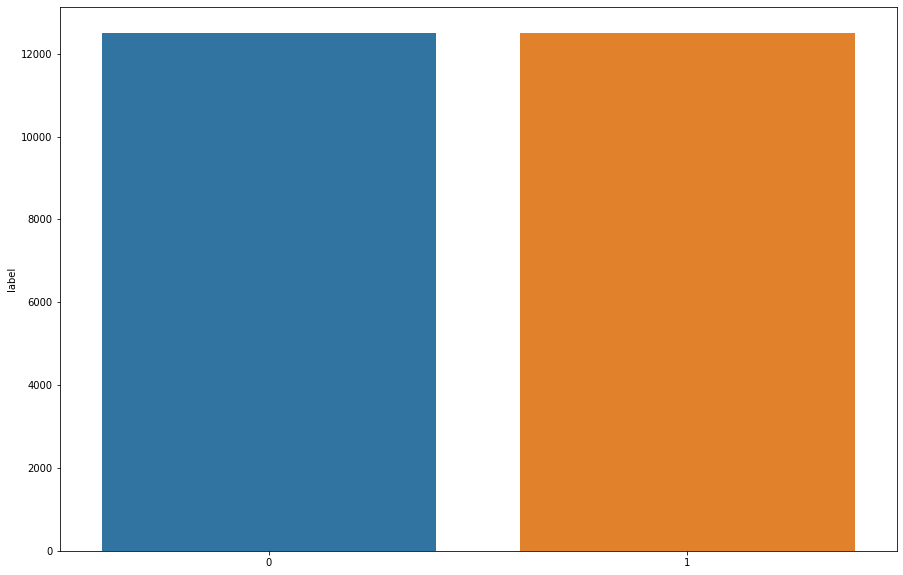

In [17]:
plt.figure(figsize=(15, 10))
count = train_df['label'].value_counts()
sns.barplot(x=count.index, y=count)

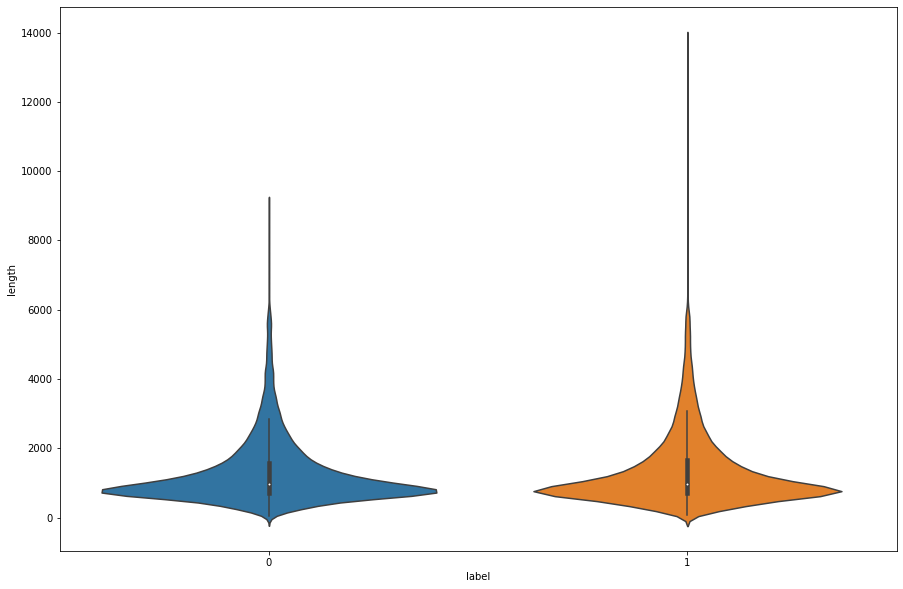

In [18]:
plt.figure(figsize=(15, 10))
sns.violinplot(data=train_df, y='length', x='label')

# Load tokenizer
- We will load our tokenizer with the gs folder we have above
- 

In [21]:
def bert_encode(text, tokenizer, max_len=512):
  tokenized_text = tokenizer.tokenize(text)
  input_seq = ["[CLS]"] + tokenized_text[:max_len-2] + ["[SEP]"]
  pad_len =  max_len - len(input_seq)
  tokens = tokenizer.convert_tokens_to_ids(input_seq)
  tokens += [0] * pad_len
  pad_masks = [1] * len(input_seq) + [0] * pad_len
  segment_ids = [0] * max_len  

  return tokens, pad_masks, segment_ids

def preproc(text):
  text = re.sub('[^0-9a-zA-Z]+', ' ', text)
  return text.lower().strip()

In [20]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

tokenizer = tokenization.FullTokenizer(
    vocab_file, do_lower_case=do_lower_case
)

In [25]:
train_df = train_df.dropna(subset=['text'])
valid_df = valid_df.dropna(subset=['text'])

In [28]:
train_text = train_df['text'].apply(lambda x: preproc(x.decode('utf-8'))).tolist()
train_labels = train_df['label'].tolist()

In [35]:
train_tokens = []
train_pad_mask = []
train_segment_ids = []

for text in train_text:
  tokens, pad_masks, segment_ids = bert_encode(text, tokenizer, max_len=100)
  train_tokens.append(tokens)
  train_pad_mask.append(pad_masks)
  train_segment_ids.append(segment_ids)

In [36]:
norm_train_ds = tf.data.Dataset.from_tensor_slices(({
    'input_ids': train_tokens,
    'pad_tokens': train_pad_mask,
    'segment_ids': train_segment_ids
}, train_labels))

In [39]:
@tf.function
def norm_labels(data, labels):
  return data, tf.one_hot(labels, 2)

norm_train_ds = norm_train_ds.shuffle(len(norm_train_ds)).map(norm_labels, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16).prefetch(tf.data.experimental.AUTOTUNE)

# Lets build our bert model

In [ ]:
def build_model(bert_layer, max_len=512):
  input_word_ids = tf.keras.layers.Input(shape=(max_len), dtype=tf.int32, name='input_words_ids')
  input_mask = tf.keras.layers.Input(shape=(max_len), dtype=tf.int32, name='input_mask')
  segment_ids = tf.keras.layers.Input(shape=(max_len), dtype=tf.int32, name='input_segment')

  _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
  clf_output = sequence_output[:, 0,:]
  fc1 = tf.keras.layers.Dense(256, activation='gelu')(clf_output)
  output = tf.keras.layers.Dense(2, activation='softmax')(fc1)

  model = tf.keras.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=output)

  return model

In [ ]:
model = build_model(bert_layer, max_len=100)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words_ids (InputLayer)    [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_segment (InputLayer)      [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_words_ids[0][0]            
                                                                 input_mask[0][0]           

In [ ]:
adamw = optimization.create_optimizer(
    2e-5, num_train_steps=1200, num_warmup_steps=100
)

In [ ]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=adamw,
    metrics=[tf.keras.metrics.Accuracy()]
)